In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
from tensorflow import keras

import IPython

!pip install -U keras-tuner
import kerastuner

     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=2130d49bd81048a982963626cc92860455072639a3b522224543869ddbdd44fa
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=3e2c46571ee696760ef25e4afcbb17e88ce4cb352286c07a0553affdaa485e8c
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [ ]:
# Importing Training Set
dataset_train = pd.read_csv('/content/gdrive/My Drive/datasets/GOOG.csv')

print(dataset_train.head())

# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:6]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print(datelist_train)

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

         Date        Open        High  ...       Close   Adj Close   Volume
0  2008-08-22  244.832306  246.515991  ...  244.379013  244.379013  4611500
1  2008-08-25  242.147369  247.572037  ...  240.603165  240.603165  4043600
2  2008-08-26  240.827316  240.827316  ...  236.194687  236.194687  6641100
3  2008-08-27  235.980484  236.528427  ...  233.415100  233.415100  8807000
4  2008-08-28  235.362808  237.335403  ...  236.005386  236.005386  6082000

[5 rows x 7 columns]
[datetime.date(2008, 8, 22), datetime.date(2008, 8, 25), datetime.date(2008, 8, 26), datetime.date(2008, 8, 27), datetime.date(2008, 8, 28), datetime.date(2008, 8, 29), datetime.date(2008, 9, 2), datetime.date(2008, 9, 3), datetime.date(2008, 9, 4), datetime.date(2008, 9, 5), datetime.date(2008, 9, 8), datetime.date(2008, 9, 9), datetime.date(2008, 9, 10), datetime.date(2008, 9, 11), datetime.date(2008, 9, 12), datetime.date(2008, 9, 15), datetime.date(2008, 9, 16), datetime.date(2008, 9, 17), datetime.date(2008, 9, 

In [ ]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (2998, 5).


array([[ 244.832306,  246.515991,  243.82608 ,  244.379013,  244.379013],
       [ 242.147369,  247.572037,  239.850983,  240.603165,  240.603165],
       [ 240.827316,  240.827316,  234.416351,  236.194687,  236.194687],
       ...,
       [1521.619995, 1523.439941, 1498.420044, 1515.550049, 1515.550049],
       [1515.26001 , 1570.290039, 1503.599976, 1565.719971, 1565.719971],
       [1586.98999 , 1586.98999 , 1554.280029, 1558.420044, 1558.420044]])

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

training_set_scaled

array([[-1.03988439, -1.04063569, -1.03585083, -1.04020883, -1.04020883],
       [-1.04718024, -1.03779417, -1.04674835, -1.05045548, -1.05045548],
       [-1.05076726, -1.05594234, -1.06164711, -1.06241891, -1.06241891],
       ...,
       [ 2.42956569,  2.39521192,  2.40355288,  2.40940922,  2.40940922],
       [ 2.41228353,  2.52127252,  2.41775339,  2.54555696,  2.54555696],
       [ 2.60719737,  2.56620745,  2.5566901 ,  2.52574691,  2.52574691]])

In [ ]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want to predict into the future (lag size)
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)


print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (2849, 90, 4).
y_train shape == (2849, 1).


In [ ]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [ ]:
def model_builder(hp):
  model = Sequential()
  model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  # Adding 2nd LSTM layer
  model.add(LSTM(units = hp_units, return_sequences=False))
  # Adding Dropout
  model.add(Dropout(0.25))
  # model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
  # model.add(keras.layers.Dense(10))

  # Output layer
  model.add(Dense(units=1, activation='linear'))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  #hP_opt = hp.Choice('', values = ['adam', '', 1e-4])
  
  model.compile(optimizer = Adam(learning_rate = hp_learning_rate),
                loss = 'mean_squared_error')
  
  return model

In [ ]:
tuner = kerastuner.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'kerastuner') 

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:

#history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)
tuner.search(X_train, y_train, epochs = 10, validation_split=0.2, batch_size=256)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Epoch 1/2
9/9 [==============================] - 11s 1s/step - loss: 2.0362 - val_loss: 0.6078
Epoch 2/2
9/9 [==============================] - 10s 1s/step - loss: 0.0972 - val_loss: 0.4847


Epoch 1/2
9/9 [==============================] - 9s 975ms/step - loss: 0.5671 - val_loss: 0.1743
Epoch 2/2
9/9 [==============================] - 8s 905ms/step - loss: 0.0295 - val_loss: 0.1342


Epoch 1/2
9/9 [==============================] - 23s 3s/step - loss: 0.1274 - val_loss: 0.1161
Epoch 2/2
9/9 [==============================] - 22s 2s/step - loss: 0.0290 - val_loss: 0.1508


Epoch 1/2
9/9 [==============================] - 7s 808ms/step - loss: 0.3817 - val_loss: 1.7535
Epoch 2/2
9/9 [==============================] - 7s 774ms/step - loss: 0.1715 - val_loss: 1.1633


Epoch 1/2
9/9 [==============================] - 7s 815ms/step - loss: 0.1802 - val_loss: 0.2201
Epoch 2/2
9/9 [==============================] - 7s 738ms/step - loss: 0.0361 - val_loss: 0.2295


Epoch 1/2
9/9 [==============================] - 28s 3s/step - loss: 11.5947 - val_loss: 2.0733
Epoch 2/2
9/9 [==============================] - 27s 3s/step - loss: 0.8424 - val_loss: 2.7950


Epoch 1/2
9/9 [==============================] - 6s 690ms/step - loss: 0.5282 - val_loss: 2.2360
Epoch 2/2
9/9 [==============================] - 6s 625ms/step - loss: 0.2569 - val_loss: 1.5929


Epoch 1/2
9/9 [==============================] - 16s 2s/step - loss: 0.1238 - val_loss: 0.1156
Epoch 2/2
9/9 [==============================] - 14s 2s/step - loss: 0.0272 - val_loss: 0.1333


Epoch 1/2
9/9 [==============================] - 6s 679ms/step - loss: 0.1405 - val_loss: 0.1469
Epoch 2/2
9/9 [==============================] - 5s 604ms/step - loss: 0.0345 - val_loss: 0.2204


Epoch 1/2
9/9 [==============================] - 11s 1s/step - loss: 0.3695 - val_loss: 1.6304
Epoch 2/2
9/9 [==============================] - 10s 1s/step - loss: 0.1164 - val_loss: 0.9322


Epoch 1/2
9/9 [==============================] - 25s 3s/step - loss: 0.1513 - val_loss: 0.2393
Epoch 2/2
9/9 [==============================] - 25s 3s/step - loss: 0.0294 - val_loss: 0.1360


Epoch 1/2
9/9 [==============================] - 25s 3s/step - loss: 9.4223 - val_loss: 6.7455
Epoch 2/2
9/9 [==============================] - 24s 3s/step - loss: 0.6635 - val_loss: 4.4615


Epoch 3/4
9/9 [==============================] - 14s 2s/step - loss: 0.1116 - val_loss: 0.1169
Epoch 4/4
9/9 [==============================] - 14s 2s/step - loss: 0.0251 - val_loss: 0.1450


Epoch 3/4
9/9 [==============================] - 23s 3s/step - loss: 0.1217 - val_loss: 0.1162
Epoch 4/4
9/9 [==============================] - 22s 2s/step - loss: 0.0267 - val_loss: 0.1306


Epoch 3/4
9/9 [==============================] - 9s 971ms/step - loss: 1.3530 - val_loss: 0.1192
Epoch 4/4
9/9 [==============================] - 8s 902ms/step - loss: 0.0474 - val_loss: 0.3517


Epoch 3/4
9/9 [==============================] - 26s 3s/step - loss: 0.1471 - val_loss: 0.1666
Epoch 4/4
9/9 [==============================] - 25s 3s/step - loss: 0.0305 - val_loss: 0.1474


Epoch 5/10
9/9 [==============================] - 23s 3s/step - loss: 0.1238 - val_loss: 0.1169
Epoch 6/10
9/9 [==============================] - 22s 2s/step - loss: 0.0251 - val_loss: 0.1510
Epoch 7/10
9/9 [==============================] - 22s 2s/step - loss: 0.0206 - val_loss: 0.1211
Epoch 8/10
9/9 [==============================] - 23s 3s/step - loss: 0.0187 - val_loss: 0.1129
Epoch 9/10
9/9 [==============================] - 22s 2s/step - loss: 0.0186 - val_loss: 0.1268
Epoch 10/10
9/9 [==============================] - 22s 2s/step - loss: 0.0182 - val_loss: 0.1323


Epoch 5/10
9/9 [==============================] - 15s 2s/step - loss: 0.1236 - val_loss: 0.1229
Epoch 6/10
9/9 [==============================] - 14s 2s/step - loss: 0.0278 - val_loss: 0.1358
Epoch 7/10
9/9 [==============================] - 14s 2s/step - loss: 0.0210 - val_loss: 0.1608
Epoch 8/10
9/9 [==============================] - 14s 2s/step - loss: 0.0194 - val_loss: 0.1145
Epoch 9/10
9/9 [==============================] - 14s 2s/step - loss: 0.0185 - val_loss: 0.1255
Epoch 10/10
9/9 [==============================] - 14s 2s/step - loss: 0.0183 - val_loss: 0.1387


Epoch 1/4
9/9 [==============================] - 20s 2s/step - loss: 0.1217 - val_loss: 0.1156
Epoch 2/4
9/9 [==============================] - 19s 2s/step - loss: 0.0258 - val_loss: 0.1410
Epoch 3/4
9/9 [==============================] - 19s 2s/step - loss: 0.0214 - val_loss: 0.1217
Epoch 4/4
9/9 [==============================] - 19s 2s/step - loss: 0.0192 - val_loss: 0.1170


Epoch 1/4
9/9 [==============================] - 17s 2s/step - loss: 4.3222 - val_loss: 0.5800
Epoch 2/4
9/9 [==============================] - 16s 2s/step - loss: 0.0961 - val_loss: 0.1685
Epoch 3/4
9/9 [==============================] - 16s 2s/step - loss: 0.1537 - val_loss: 0.1358
Epoch 4/4
9/9 [==============================] - 16s 2s/step - loss: 0.1314 - val_loss: 0.9807


Epoch 1/4
9/9 [==============================] - 5s 582ms/step - loss: 0.2288 - val_loss: 0.5946
Epoch 2/4
9/9 [==============================] - 4s 490ms/step - loss: 0.0368 - val_loss: 0.1967
Epoch 3/4
9/9 [==============================] - 5s 501ms/step - loss: 0.0263 - val_loss: 0.1250
Epoch 4/4
9/9 [==============================] - 5s 506ms/step - loss: 0.0214 - val_loss: 0.1131


Epoch 1/4
9/9 [==============================] - 10s 1s/step - loss: 0.1379 - val_loss: 0.1489
Epoch 2/4
9/9 [==============================] - 10s 1s/step - loss: 0.0321 - val_loss: 0.1612
Epoch 3/4
9/9 [==============================] - 10s 1s/step - loss: 0.0224 - val_loss: 0.1563
Epoch 4/4
9/9 [==============================] - 10s 1s/step - loss: 0.0198 - val_loss: 0.1232


Epoch 1/4
9/9 [==============================] - 4s 479ms/step - loss: 0.4422 - val_loss: 0.2329
Epoch 2/4
9/9 [==============================] - 4s 425ms/step - loss: 0.0487 - val_loss: 0.1111
Epoch 3/4
9/9 [==============================] - 4s 412ms/step - loss: 0.0344 - val_loss: 0.1861
Epoch 4/4
9/9 [==============================] - 4s 402ms/step - loss: 0.0259 - val_loss: 0.1438


Epoch 1/4
9/9 [==============================] - 14s 2s/step - loss: 0.1308 - val_loss: 0.1789
Epoch 2/4
9/9 [==============================] - 13s 1s/step - loss: 0.0332 - val_loss: 0.1231
Epoch 3/4
9/9 [==============================] - 13s 1s/step - loss: 0.0206 - val_loss: 0.1389
Epoch 4/4
9/9 [==============================] - 15s 2s/step - loss: 0.0198 - val_loss: 0.1330


Epoch 5/10
9/9 [==============================] - 5s 547ms/step - loss: 0.2576 - val_loss: 0.1580
Epoch 6/10
9/9 [==============================] - 4s 420ms/step - loss: 0.0485 - val_loss: 0.3735
Epoch 7/10
9/9 [==============================] - 4s 446ms/step - loss: 0.0324 - val_loss: 0.1190
Epoch 8/10
9/9 [==============================] - 4s 419ms/step - loss: 0.0259 - val_loss: 0.1151
Epoch 9/10
9/9 [==============================] - 4s 410ms/step - loss: 0.0236 - val_loss: 0.1387
Epoch 10/10
9/9 [==============================] - 4s 406ms/step - loss: 0.0226 - val_loss: 0.1152


Epoch 5/10
9/9 [==============================] - 5s 606ms/step - loss: 0.2493 - val_loss: 0.5788
Epoch 6/10
9/9 [==============================] - 6s 618ms/step - loss: 0.0396 - val_loss: 0.1628
Epoch 7/10
9/9 [==============================] - 5s 595ms/step - loss: 0.0262 - val_loss: 0.1293
Epoch 8/10
9/9 [==============================] - 5s 562ms/step - loss: 0.0208 - val_loss: 0.1139
Epoch 9/10
9/9 [==============================] - 5s 573ms/step - loss: 0.0201 - val_loss: 0.1342
Epoch 10/10
9/9 [==============================] - 5s 575ms/step - loss: 0.0192 - val_loss: 0.1518


Epoch 1/10
9/9 [==============================] - 26s 3s/step - loss: 0.3436 - val_loss: 1.0515
Epoch 2/10
9/9 [==============================] - 24s 3s/step - loss: 0.0639 - val_loss: 0.2962
Epoch 3/10
9/9 [==============================] - 23s 3s/step - loss: 0.0418 - val_loss: 0.2540
Epoch 4/10
9/9 [==============================] - 23s 3s/step - loss: 0.0265 - val_loss: 0.1746
Epoch 5/10
9/9 [==============================] - 24s 3s/step - loss: 0.0217 - val_loss: 0.1096
Epoch 6/10
9/9 [==============================] - 24s 3s/step - loss: 0.0204 - val_loss: 0.1120
Epoch 7/10
9/9 [==============================] - 24s 3s/step - loss: 0.0200 - val_loss: 0.1118
Epoch 8/10
9/9 [==============================] - 23s 3s/step - loss: 0.0195 - val_loss: 0.1122
Epoch 9/10
9/9 [==============================] - 23s 3s/step - loss: 0.0190 - val_loss: 0.1139
Epoch 10/10
9/9 [==============================] - 23s 3s/step - loss: 0.0191 - val_loss: 0.1170


Epoch 1/10
9/9 [==============================] - 30s 3s/step - loss: 0.1588 - val_loss: 0.1731
Epoch 2/10
9/9 [==============================] - 29s 3s/step - loss: 0.0306 - val_loss: 0.1387
Epoch 3/10
9/9 [==============================] - 28s 3s/step - loss: 0.0241 - val_loss: 0.1209
Epoch 4/10
9/9 [==============================] - 28s 3s/step - loss: 0.0195 - val_loss: 0.1341
Epoch 5/10
9/9 [==============================] - 28s 3s/step - loss: 0.0189 - val_loss: 0.1160
Epoch 6/10
9/9 [==============================] - 28s 3s/step - loss: 0.0183 - val_loss: 0.1209
Epoch 7/10
9/9 [==============================] - 28s 3s/step - loss: 0.0179 - val_loss: 0.1251
Epoch 8/10
9/9 [==============================] - 28s 3s/step - loss: 0.0179 - val_loss: 0.1196
Epoch 9/10
9/9 [==============================] - 29s 3s/step - loss: 0.0176 - val_loss: 0.1196
Epoch 10/10
9/9 [==============================] - 29s 3s/step - loss: 0.0175 - val_loss: 0.1217


Epoch 1/10
9/9 [==============================] - 6s 707ms/step - loss: 0.5073 - val_loss: 0.1715
Epoch 2/10
9/9 [==============================] - 6s 655ms/step - loss: 0.0469 - val_loss: 0.4381
Epoch 3/10
9/9 [==============================] - 6s 644ms/step - loss: 0.0265 - val_loss: 0.3357
Epoch 4/10
9/9 [==============================] - 6s 626ms/step - loss: 0.0220 - val_loss: 0.1183
Epoch 5/10
9/9 [==============================] - 6s 626ms/step - loss: 0.0201 - val_loss: 0.1190
Epoch 6/10
9/9 [==============================] - 6s 642ms/step - loss: 0.0195 - val_loss: 0.1169
Epoch 7/10
9/9 [==============================] - 6s 629ms/step - loss: 0.0196 - val_loss: 0.1139
Epoch 8/10
9/9 [==============================] - 6s 628ms/step - loss: 0.0194 - val_loss: 0.1147
Epoch 9/10
9/9 [==============================] - 6s 635ms/step - loss: 0.0192 - val_loss: 0.1112
Epoch 10/10
9/9 [==============================] - 6s 641ms/step - loss: 0.0190 - val_loss: 0.1213


Epoch 1/10
9/9 [==============================] - 4s 489ms/step - loss: 0.2604 - val_loss: 0.1799
Epoch 2/10
9/9 [==============================] - 4s 408ms/step - loss: 0.0464 - val_loss: 0.1139
Epoch 3/10
9/9 [==============================] - 4s 408ms/step - loss: 0.0382 - val_loss: 0.1112
Epoch 4/10
9/9 [==============================] - 4s 406ms/step - loss: 0.0278 - val_loss: 0.2443
Epoch 5/10
9/9 [==============================] - 4s 398ms/step - loss: 0.0251 - val_loss: 0.1364
Epoch 6/10
9/9 [==============================] - 4s 410ms/step - loss: 0.0231 - val_loss: 0.1309
Epoch 7/10
9/9 [==============================] - 4s 415ms/step - loss: 0.0226 - val_loss: 0.1505
Epoch 8/10
9/9 [==============================] - 4s 420ms/step - loss: 0.0209 - val_loss: 0.1590
Epoch 9/10
9/9 [==============================] - 4s 419ms/step - loss: 0.0217 - val_loss: 0.1275
Epoch 10/10
9/9 [==============================] - 4s 419ms/step - loss: 0.0213 - val_loss: 0.1260


INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384 and the optimal learning rate for the optimizer
is 0.0001.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
#tuner.search(X_train, y_train, epochs = 10, validation_split=0.2, batch_size=256)
model.fit(X_train, y_train, epochs = 10, validation_split=0.2)

Epoch 1/10
72/72 [==============================] - 47s 656ms/step - loss: 0.0581 - val_loss: 0.1152
Epoch 2/10
72/72 [==============================] - 47s 658ms/step - loss: 0.0187 - val_loss: 0.1191
Epoch 3/10
72/72 [==============================] - 48s 660ms/step - loss: 0.0182 - val_loss: 0.1107
Epoch 4/10
72/72 [==============================] - 47s 655ms/step - loss: 0.0181 - val_loss: 0.1163
Epoch 5/10
72/72 [==============================] - 46s 640ms/step - loss: 0.0178 - val_loss: 0.1210
Epoch 6/10
72/72 [==============================] - 46s 635ms/step - loss: 0.0178 - val_loss: 0.1111
Epoch 7/10
72/72 [==============================] - 46s 641ms/step - loss: 0.0180 - val_loss: 0.1117
Epoch 8/10
72/72 [==============================] - 46s 639ms/step - loss: 0.0182 - val_loss: 0.1093
Epoch 9/10
72/72 [==============================] - 47s 653ms/step - loss: 0.0181 - val_loss: 0.1100
Epoch 10/10
72/72 [==============================] - 48s 665ms/step - loss: 0.0177 - val_lo

In [ ]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()
print(datelist_future)
'''
Remeber, we have datelist_train from begining.
'''
print("___________________________________________________________________________________________")
# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())


[Timestamp('2020-07-21 00:00:00', freq='D'), Timestamp('2020-07-22 00:00:00', freq='D'), Timestamp('2020-07-23 00:00:00', freq='D'), Timestamp('2020-07-24 00:00:00', freq='D'), Timestamp('2020-07-25 00:00:00', freq='D'), Timestamp('2020-07-26 00:00:00', freq='D'), Timestamp('2020-07-27 00:00:00', freq='D'), Timestamp('2020-07-28 00:00:00', freq='D'), Timestamp('2020-07-29 00:00:00', freq='D'), Timestamp('2020-07-30 00:00:00', freq='D'), Timestamp('2020-07-31 00:00:00', freq='D'), Timestamp('2020-08-01 00:00:00', freq='D'), Timestamp('2020-08-02 00:00:00', freq='D'), Timestamp('2020-08-03 00:00:00', freq='D'), Timestamp('2020-08-04 00:00:00', freq='D'), Timestamp('2020-08-05 00:00:00', freq='D'), Timestamp('2020-08-06 00:00:00', freq='D'), Timestamp('2020-08-07 00:00:00', freq='D'), Timestamp('2020-08-08 00:00:00', freq='D'), Timestamp('2020-08-09 00:00:00', freq='D'), Timestamp('2020-08-10 00:00:00', freq='D'), Timestamp('2020-08-11 00:00:00', freq='D'), Timestamp('2020-08-12 00:00:00'

In [ ]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [ ]:
sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-1.03988439],
       [-1.04718024],
       [-1.05076726],
       ...,
       [ 2.42956569],
       [ 2.41228353],
       [ 2.60719737]])

In [ ]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Open
2009-08-05,221.308624
2009-08-06,221.997925
2009-08-07,222.434601


In [ ]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


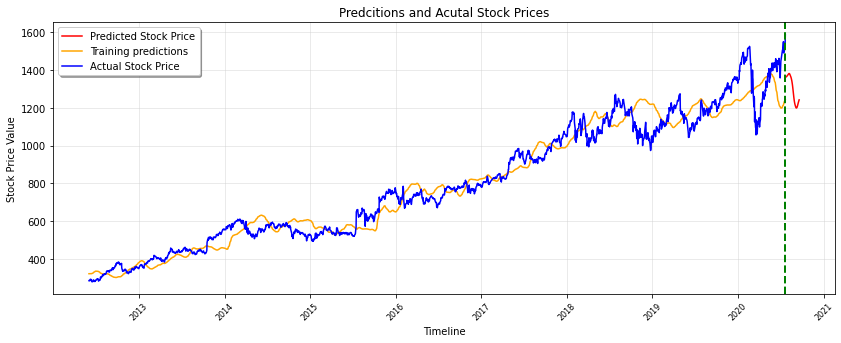

In [ ]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2012-06-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

**Baysian**

In [ ]:
tuner = kerastuner.BayesianOptimization(model_builder,
                     objective = 'val_loss',
                     max_trials = 5)

In [ ]:

#history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)
tuner.search(X_train, y_train, epochs = 10, validation_split=0.2, batch_size=256)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Epoch 1/10
9/9 [==============================] - 24s 3s/step - loss: 0.3950 - val_loss: 1.3254
Epoch 2/10
9/9 [==============================] - 23s 3s/step - loss: 0.0858 - val_loss: 0.3846
Epoch 3/10
9/9 [==============================] - 23s 3s/step - loss: 0.0527 - val_loss: 0.2870
Epoch 4/10
9/9 [==============================] - 23s 3s/step - loss: 0.0293 - val_loss: 0.2102
Epoch 5/10
9/9 [==============================] - 23s 3s/step - loss: 0.0242 - val_loss: 0.1126
Epoch 6/10
9/9 [==============================] - 23s 3s/step - loss: 0.0217 - val_loss: 0.1250
Epoch 7/10
9/9 [==============================] - 23s 3s/step - loss: 0.0207 - val_loss: 0.1128
Epoch 8/10
9/9 [==============================] - 23s 3s/step - loss: 0.0201 - val_loss: 0.1122
Epoch 9/10
9/9 [==============================] - 23s 3s/step - loss: 0.0195 - val_loss: 0.1118
Epoch 10/10
9/9 [==============================] - 23s 3s/step - loss: 0.0195 - val_loss: 0.1130


Epoch 1/10
9/9 [==============================] - 16s 2s/step - loss: 0.1252 - val_loss: 0.1816
Epoch 2/10
9/9 [==============================] - 15s 2s/step - loss: 0.0327 - val_loss: 0.1288
Epoch 3/10
9/9 [==============================] - 15s 2s/step - loss: 0.0220 - val_loss: 0.1740
Epoch 4/10
9/9 [==============================] - 15s 2s/step - loss: 0.0200 - val_loss: 0.1410
Epoch 5/10
9/9 [==============================] - 15s 2s/step - loss: 0.0188 - val_loss: 0.1206
Epoch 6/10
9/9 [==============================] - 15s 2s/step - loss: 0.0186 - val_loss: 0.1480
Epoch 7/10
9/9 [==============================] - 15s 2s/step - loss: 0.0182 - val_loss: 0.1366
Epoch 8/10
9/9 [==============================] - 15s 2s/step - loss: 0.0178 - val_loss: 0.1285
Epoch 9/10
9/9 [==============================] - 15s 2s/step - loss: 0.0181 - val_loss: 0.1282
Epoch 10/10
9/9 [==============================] - 15s 2s/step - loss: 0.0178 - val_loss: 0.1245


Epoch 1/10
9/9 [==============================] - 3s 361ms/step - loss: 0.2008 - val_loss: 0.4036
Epoch 2/10
9/9 [==============================] - 3s 286ms/step - loss: 0.0347 - val_loss: 0.2671
Epoch 3/10
9/9 [==============================] - 2s 275ms/step - loss: 0.0317 - val_loss: 0.2250
Epoch 4/10
9/9 [==============================] - 3s 286ms/step - loss: 0.0259 - val_loss: 0.1334
Epoch 5/10
9/9 [==============================] - 3s 290ms/step - loss: 0.0245 - val_loss: 0.1658
Epoch 6/10
9/9 [==============================] - 3s 292ms/step - loss: 0.0233 - val_loss: 0.1696
Epoch 7/10
9/9 [==============================] - 2s 277ms/step - loss: 0.0221 - val_loss: 0.2087
Epoch 8/10
9/9 [==============================] - 2s 276ms/step - loss: 0.0214 - val_loss: 0.2833
Epoch 9/10
9/9 [==============================] - 3s 285ms/step - loss: 0.0225 - val_loss: 0.2186
Epoch 10/10
9/9 [==============================] - 3s 286ms/step - loss: 0.0222 - val_loss: 0.1655


Epoch 1/10
9/9 [==============================] - 40s 4s/step - loss: 18.5304 - val_loss: 0.1545
Epoch 2/10
9/9 [==============================] - 39s 4s/step - loss: 1.8935 - val_loss: 1.8751
Epoch 3/10
9/9 [==============================] - 40s 4s/step - loss: 0.3498 - val_loss: 2.7875
Epoch 4/10
9/9 [==============================] - 40s 4s/step - loss: 0.2640 - val_loss: 1.0293
Epoch 5/10
9/9 [==============================] - 39s 4s/step - loss: 0.1845 - val_loss: 0.7677
Epoch 6/10
9/9 [==============================] - 38s 4s/step - loss: 0.1178 - val_loss: 0.8100
Epoch 7/10
9/9 [==============================] - 40s 4s/step - loss: 0.0705 - val_loss: 0.5421
Epoch 8/10
9/9 [==============================] - 39s 4s/step - loss: 0.0524 - val_loss: 0.3251
Epoch 9/10
9/9 [==============================] - 39s 4s/step - loss: 0.0407 - val_loss: 0.2298
Epoch 10/10
9/9 [==============================] - 40s 4s/step - loss: 0.0339 - val_loss: 0.2153


Epoch 1/10
9/9 [==============================] - 3s 371ms/step - loss: 0.4669 - val_loss: 2.3507
Epoch 2/10
9/9 [==============================] - 3s 287ms/step - loss: 0.3026 - val_loss: 1.9652
Epoch 3/10
9/9 [==============================] - 3s 284ms/step - loss: 0.1850 - val_loss: 1.6510
Epoch 4/10
9/9 [==============================] - 3s 285ms/step - loss: 0.1210 - val_loss: 1.3982
Epoch 5/10
9/9 [==============================] - 3s 279ms/step - loss: 0.0847 - val_loss: 1.1983
Epoch 6/10
9/9 [==============================] - 3s 289ms/step - loss: 0.0761 - val_loss: 1.0335
Epoch 7/10
9/9 [==============================] - 3s 290ms/step - loss: 0.0687 - val_loss: 0.8928
Epoch 8/10
9/9 [==============================] - 3s 289ms/step - loss: 0.0573 - val_loss: 0.7687
Epoch 9/10
9/9 [==============================] - 3s 288ms/step - loss: 0.0509 - val_loss: 0.6595
Epoch 10/10
9/9 [==============================] - 3s 295ms/step - loss: 0.0449 - val_loss: 0.5627


INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384 and the optimal learning rate for the optimizer
is 0.0001.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
#tuner.search(X_train, y_train, epochs = 10, validation_split=0.2, batch_size=256)
model.fit(X_train, y_train, epochs = 10, validation_split=0.2)

Epoch 1/10
72/72 [==============================] - 46s 643ms/step - loss: 0.0904 - val_loss: 0.1095
Epoch 2/10
72/72 [==============================] - 46s 636ms/step - loss: 0.0187 - val_loss: 0.1313
Epoch 3/10
72/72 [==============================] - 47s 647ms/step - loss: 0.0183 - val_loss: 0.1156
Epoch 4/10
72/72 [==============================] - 46s 635ms/step - loss: 0.0179 - val_loss: 0.1260
Epoch 5/10
72/72 [==============================] - 47s 654ms/step - loss: 0.0177 - val_loss: 0.1214
Epoch 6/10
72/72 [==============================] - 46s 645ms/step - loss: 0.0178 - val_loss: 0.1207
Epoch 7/10
72/72 [==============================] - 46s 641ms/step - loss: 0.0177 - val_loss: 0.1088
Epoch 8/10
72/72 [==============================] - 46s 634ms/step - loss: 0.0175 - val_loss: 0.1195
Epoch 9/10
72/72 [==============================] - 47s 650ms/step - loss: 0.0174 - val_loss: 0.1096
Epoch 10/10
72/72 [==============================] - 46s 636ms/step - loss: 0.0179 - val_lo

In [ ]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()
print(datelist_future)
'''
Remeber, we have datelist_train from begining.
'''
print("___________________________________________________________________________________________")
# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

[Timestamp('2020-07-21 00:00:00', freq='D'), Timestamp('2020-07-22 00:00:00', freq='D'), Timestamp('2020-07-23 00:00:00', freq='D'), Timestamp('2020-07-24 00:00:00', freq='D'), Timestamp('2020-07-25 00:00:00', freq='D'), Timestamp('2020-07-26 00:00:00', freq='D'), Timestamp('2020-07-27 00:00:00', freq='D'), Timestamp('2020-07-28 00:00:00', freq='D'), Timestamp('2020-07-29 00:00:00', freq='D'), Timestamp('2020-07-30 00:00:00', freq='D'), Timestamp('2020-07-31 00:00:00', freq='D'), Timestamp('2020-08-01 00:00:00', freq='D'), Timestamp('2020-08-02 00:00:00', freq='D'), Timestamp('2020-08-03 00:00:00', freq='D'), Timestamp('2020-08-04 00:00:00', freq='D'), Timestamp('2020-08-05 00:00:00', freq='D'), Timestamp('2020-08-06 00:00:00', freq='D'), Timestamp('2020-08-07 00:00:00', freq='D'), Timestamp('2020-08-08 00:00:00', freq='D'), Timestamp('2020-08-09 00:00:00', freq='D'), Timestamp('2020-08-10 00:00:00', freq='D'), Timestamp('2020-08-11 00:00:00', freq='D'), Timestamp('2020-08-12 00:00:00'

In [ ]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-1.03988439],
       [-1.04718024],
       [-1.05076726],
       ...,
       [ 2.42956569],
       [ 2.41228353],
       [ 2.60719737]])

In [ ]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Open
2009-08-05,220.364594
2009-08-06,221.108765
2009-08-07,221.646271


In [ ]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

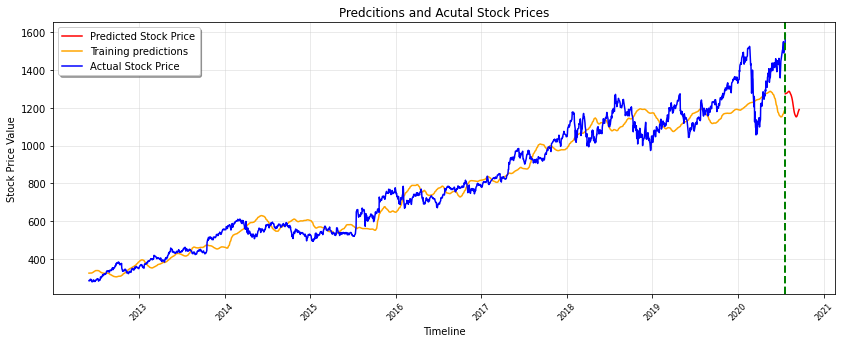

In [ ]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2012-06-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()